# Modeling Integrase Activity
The goal of this notebook is to model integrase activity in TX-TL using mechanistic chemical reaction network models.

## Integrase Expression and Activitiy Modeling:
The first step is to characterize integrase activity independent of the excisionase. For this, we design a two plasmid system - (1) Bxb1 integrase expressing plasmid fused with CFP to measure integrase expression, and (2) YFP plasmid that gets activated on integrase action. Hence, using this experiment we would like to model integrase expression and its action on flipping a promoter of a fluorescent reporter. The goal of the experiment would be to characterize the integrase flipping activity parameter(s) and to study any context effects due to TX-TL such as loading. 

Towards this first goal, we model the two plasmid system in TX-TL using a mechanistic chemical reaction network using BioCRNpyler. We simulate this detailed CRN model using a fast Cython-based simulator called Bioscrape. From simulations of the CRN model, we explore the design space and context effects since this model consists the details of resource usage mechanisms for RNA polymerase, ribosomes, etc. However, the detailed model is difficult to fit using the available data due to the problem of unidentifiability and high-dimensionality. We explore these effects by running sensitivity analysis tools implemented as part of the Bioscrape software. To get around this problem of unidentifiability, we automatically derive potential reduced models for this system using Python-based automated model reduction software called, AutoReduce. We choose a reduced model that recovers the desired properties (integrase flipping, fluorescent reporter levels, and any other important context effects). For this lower-dimensional reduced model, we use Bayesian inference to fit the TX-TL data. The parameter inference pipeline is implemented in Bioscrape as a black-box Python wrapper for Python emcee. Hence, the "full-stack" Python pipeline of modeling, design-space exploration, sensitivity analysis, model reduction, and parameter inference gives us a validated mathematical model for integrase activity in TX-TL. 

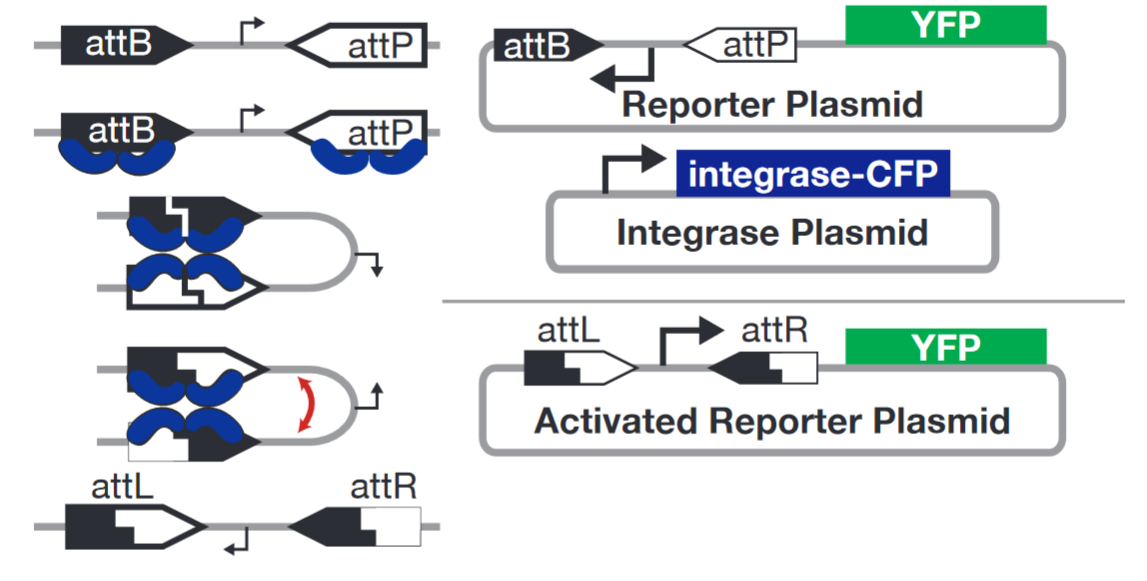

## Chemical Reaction Network (CRN) models:

In [1]:
##
# Author: Ayush Pandey
##
from biocrnpyler import *


C:\Users\apand\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from cycler import cycler
import numpy as np
import bioscrape as bs

sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 1.5})
sns.set_style("ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})

#%config InlineBackend.figure_f.ormats=['svg']

mpl.rc('axes', prop_cycle=(cycler('color', ['r', 'k', 'b','g','y','m','c']) ))

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Helvetica'
# mpl.rc('text', usetex=False)
# mpl.rc('text.latex', preamble=r'\usepackage{helvet}\
# \renewcommand\familydefault{\sfdefault}\usepackage{sansmath}\sansmath')
# mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 
#                  'serif': ['Helvetica']})

tw = 1.5
sns.set_style({"xtick.major.size": 3, "ytick.major.size": 3,
               "xtick.minor.size": 2, "ytick.minor.size": 2,
               'axes.labelsize': 16, 'axes.titlesize': 16,
               'xtick.major.width': tw, 'xtick.minor.width': tw,
               'ytick.major.width': tw, 'ytick.minor.width': tw})

mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', linewidth=1.5, titlesize=14, labelsize=14)
mpl.rc('legend', fontsize=14)
mpl.rc('figure', figsize=(8.5,15))

C:\Users\apand\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Integrase flipping CRN:

Integrase flipping CRN:

$attB + 2 I \rightleftharpoons attB:I_2$

$attP + 2 I \rightleftharpoons attP:I_2$

$attB:I_2 + attP:I_2 \xrightarrow{k_{int}} attL:I_2 + attR:I_2$

$attL:I_2 + attR:I_2 \rightleftharpoons A + 4I$

$ A \rightarrow Y + A$

where $I$ is the integrase, $A$ is activated plasmid (integrase flipped) and $Y$ is the reporter protein concentration.

We can further simplify the above CRN to represent the measurements that we have for integrase and flipped plasmid (CFP and YFP respectively).

Let R = unactivated reporter plasmid = attB--attP plasmid. So we can write:

$ \varnothing \rightarrow I $

$4 I + R \rightleftharpoons C$

$C \rightarrow C_A$

$ C_A \rightleftharpoons A + 4I$

$ A \rightarrow Y + A$

### Create IntegraseSite component and IntegraseFlipper mechanism to model integrase activity

In [13]:
from itertools import chain
class IntegraseSite(Component):
    def __init__(self, integrase: Species, 
                 curr_dna: Species, reversed_dna: Species, 
                 name: str=None, cooperativity: int=1, parameter_dict = None,
                 mechanism = None, **keywords):

#         self.species = Complex(species=self.internal_species, name=name, 
#         material_type=material_type, attributes=attributes)
        if name is None:
            name = integrase.name
        self.name = name
        self.integrase = integrase
        self.curr_dna = curr_dna
        self.reversed_dna = reversed_dna
        self.complex_species = None
        self.flipped_complex = None
        self.species = None
#         self.species = [integrase, curr_dna, reversed_dna]
        self.cooperativity = cooperativity
        self.parameter_dict = parameter_dict
        mechanisms = {mechanism.mechanism_type:mechanism}
        Component.__init__(self=self, name=name, mechanisms=mechanisms, **keywords)
        
    def get_species(self) -> List[Species]:
        return self.species

    def update_species(self) -> List[Species]:
        integrase_flipper = self.get_mechanism('integrase-flipper')
        self.species = integrase_flipper.update_species(integrase = self.integrase, 
                                                        curr_dna = self.curr_dna, 
                                                        reversed_dna = self.reversed_dna, 
                                                        cooperativity = self.cooperativity)
        return self.species

    def update_reactions(self) -> List[Reaction]:
        integrase_flipper = self.get_mechanism('integrase-flipper')
        return integrase_flipper.update_reactions(integrase = self.integrase, curr_dna = self.curr_dna, 
                                                  reversed_dna = self.reversed_dna, cooperativity = self.cooperativity,
                                                  complex_species = self.complex_species, 
                                                  flipped_complex = self.flipped_complex, 
                                                  component = self, 
                                                  part_id = None, parameter_dict = self.parameter_dict)


class IntegraseFlipper(Mechanism):
    """Mechanism for the simple integrase flipping. 
    Integrase binds to attP-attB site, forms a complex,
    the complex flips the site to attL-attR, then integrase unbinds.
    """
    def __init__(self, name: str="integrase-flipper", mechanism_type: str="integrase-flipper", **keywords):
        """Initializes a IntegraseFlipper instance.
        :param name: name of the Mechanism, default: integrase-flipper
        :param mechanism_type: type of the Mechanism, default: integrase-flipper
        :param keywords:
        """
        Mechanism.__init__(self, name, mechanism_type)

    def update_species(self, integrase, curr_dna, reversed_dna, cooperativity):
        list_of_species = [cooperativity*[integrase], [curr_dna]]
        # attP_attB_4I
        complex_species = Complex(species = list_of_species)
        self.complex_species = complex_species
        # attL_attR_4I
        list_of_species = [cooperativity*[integrase], [reversed_dna]]
        flipped_complex = Complex(species = list_of_species)
        self.flipped_complex = flipped_complex
        return [integrase, curr_dna, reversed_dna, 
                complex_species, flipped_complex]

    def update_reactions(self, integrase, curr_dna, reversed_dna, cooperativity,
                         complex_species, flipped_complex, component = None, 
                         part_id = None, parameter_dict = None):
        if part_id is None and component is not None:
            part_id = component.name
        if parameter_dict is None and component is None:
            raise ValueError("Must pass in either a component or a parameter dictionary.")
        elif parameter_dict is None:
            a_i = component.get_parameter("a_i", part_id = part_id, mechanism = self)
            d_i = component.get_parameter("d_i", part_id = part_id, mechanism = self)
            k_int = component.get_parameter("k_int", part_id = part_id, mechanism = self)
            a_r = component.get_parameter("a_r", part_id = part_id, mechanism = self)
            d_r = component.get_parameter("d_r", part_id = part_id, mechanism = self)
        else:
            a_i = parameter_dict['a_i']
            d_i = parameter_dict['d_i']
            k_int = parameter_dict['k_int']
            a_r = parameter_dict['a_r']
            d_r = parameter_dict['d_r']
        
        if complex_species is None:
            if self.complex_species is None:
                raise ValueError('The complex_species is not set for mechanism {0}'.format(self.name))
            complex_species = self.complex_species
        if flipped_complex is None:
            if self.flipped_complex is None:
                raise ValueError('The flipped_species is not set for mechanism {0}'.format(self.name))
            flipped_complex = self.flipped_complex   
        list_of_species = [cooperativity*[integrase], [curr_dna]]
        integrase_binding_reaction = Reaction.from_massaction([item for sublist in list_of_species for item in sublist],
                                                              [complex_species],
                                                              k_forward = a_i, k_reverse = d_i)
        flipping_reaction = Reaction.from_massaction([complex_species], [flipped_complex], k_forward = k_int)
        
        list_of_species = [cooperativity*[integrase], [reversed_dna]]
        integrase_unbinding_reaction = Reaction.from_massaction([flipped_complex],
                                                                [item for sublist in list_of_species for item in sublist],
                                                                k_forward = a_r, k_reverse = d_r)
        reactions = [integrase_binding_reaction, flipping_reaction, integrase_unbinding_reaction]
        return reactions

## Model TX-TL context using the TxTlMixture class:

In [14]:
class TxTlMixture(Mixture):
    def __init__(self, name="", rnap="RNAP", ribosome="Ribo", rnaase="RNAase", **kwargs):
        Mixture.__init__(self, name=name, **kwargs)

        # Create Components for TxTl machinery
        self.rnap = Protein(rnap)
        self.ribosome = Protein(ribosome)
#         self.rnap.add_attribute("machinery")
#         self.ribosome.add_attribute("machinery")
        self.rnaase = Protein(rnaase)
        default_components = [
            self.rnap, self.ribosome, self.rnaase
        ]
        self.add_components(default_components)

        #Create TxTl Mechansisms
        mech_tx = Transcription_MM(rnap = self.rnap.get_species())
        mech_tl = Translation_MM(ribosome = self.ribosome.get_species())
        mech_rna_deg = Degredation_mRNA_MM(nuclease=self.rnaase.get_species())
        mech_cat = MichaelisMenten()
        mech_bind = One_Step_Binding()

#         #Create Global Dilution Mechanisms
        dilution_mechanism = Dilution(filter_dict = {"rna":True, "machinery":False}, 
                                      default_on = False)
        default_mechanisms = {
            mech_tx.mechanism_type: mech_tx,
            mech_tl.mechanism_type: mech_tl,
            mech_cat.mechanism_type: mech_cat,
            mech_bind.mechanism_type:mech_bind,
            "dilution":mech_rna_deg,
        }

        self.add_mechanisms(default_mechanisms)

## Define parameters

In [15]:
parameters_dict = {("transcription_mm", "P_int", "kb"):100, 
                   ("transcription_mm", "P_int", "ku"):10,
                   ("transcription_mm", "P_int", "ktx"):0.5,
                   ("translation_mm", "RBS1", "kb"):100, 
                   ("translation_mm", "RBS1", "ku"):10,
                   ("translation_mm", "RBS1", "ktl"):2,
                   ("translation_mm", "RBS2", "kb"):100, 
                   ("translation_mm", "RBS2", "ku"):10,
                   ("translation_mm", "RBS2", "ktl"):2,
                   ("transcription_mm", "P_A", "kb"):80, 
                   ("transcription_mm", "P_A", "ku"):20,
                   ("transcription_mm", "P_A", "ktx"):0.3,
                   ("rna_degredation_mm", "rna_T_int", "kb"):20,
                   ("rna_degredation_mm", "rna_T_int", "ku"):2,
                   ("rna_degredation_mm", "rna_T_A", "kb"):20,
                   ("rna_degredation_mm", "rna_T_A", "ku"):2,
                   ("rna_degredation_mm", "rna_T_int", "kdeg"):0.05,
                   ("rna_degredation_mm", "rna_T_A", "kdeg"):0.05,
                   ("rna_degredation_mm", "complex_protein_Ribo_rna_T_int_", "kb"): 20,
                   ("rna_degredation_mm", "complex_protein_Ribo_rna_T_int_", "ku"): 2,
                   ("rna_degredation_mm", "complex_protein_Ribo_rna_T_int_", "kdeg"): 0.05,
                   ("rna_degredation_mm", "complex_protein_Ribo_rna_T_A_", "kb"): 20,
                   ("rna_degredation_mm", "complex_protein_Ribo_rna_T_A_", "ku"): 2,
                   ("rna_degredation_mm", "complex_protein_Ribo_rna_T_A_", "kdeg"): 0.05
                   }
#                    ("global_degredation_via_dilution", "protein_Int", "kdil"):0.01,
#                    ("global_degredation_via_dilution", "protein_Y", "kdil"):0.01} 

# Measures E.coli extract endogenous mRNA degradation:
# https://jbioleng.biomedcentral.com/track/pdf/10.1186/1754-1611-4-9.pdf

In [16]:
# Integrase binding to DNA
a_i = ParameterEntry("a_i", 30)
# Integrase unbinding DNA
d_i = ParameterEntry("d_i", 0.01)

# Integrase flipping rate
k_int = ParameterEntry("k_int", 0.1)

# Integrase-attL_attR complex unbinding to form attL_attR and Integrase
a_r = ParameterEntry("a_r", 10)
# Binding of attL_attR and I to form Integrase-attL_attR complex 
d_r = ParameterEntry("d_r", 0.01)

parameters_integrase = {'a_i':a_i, 'd_i':d_i, 'k_int':k_int, 'a_r':a_r, 'd_r':d_r}

G_int = DNAassembly("G_int", promoter = "P_int", rbs = "RBS1", transcript = "T_int", protein = "Int")
G = DNAassembly("attL_attR", promoter = "P_A", rbs = "RBS2", transcript = "T_A", protein = "Y")
U = Species("attP_attB", material_type = "dna")
I0_mech = IntegraseFlipper()
I0 = IntegraseSite(integrase = G_int.protein, curr_dna = U, reversed_dna = G.dna,  
                   cooperativity = 2, parameter_dict = parameters_integrase,
                   mechanism = I0_mech)
M = TxTlMixture("Gene_Expr_Mix", components = [G_int, I0, G], 
                 parameters = parameters_dict)
CRN = M.compile_crn()
CRN.add_species(U)
CRN.write_sbml_file("integrase_txtl_resources.xml")

True

In [7]:
CRN

Species = dna_G_int, protein_RNAP, rna_T_int, complex_dna_G_int_protein_RNAP_, protein_Ribo, protein_Int, complex_protein_Ribo_rna_T_int_, dna_attP_attB, dna_attL_attR, complex_dna_attP_attB_protein_Int_2x_, complex_dna_attL_attR_protein_Int_2x_, rna_T_A, complex_dna_attL_attR_protein_RNAP_, protein_Y, complex_protein_Ribo_rna_T_A_, protein_RNAase, complex_protein_RNAase_rna_T_int_, complex_complex_protein_Ribo_rna_T_int__protein_RNAase_, complex_protein_RNAase_rna_T_A_, complex_complex_protein_Ribo_rna_T_A__protein_RNAase_
Reactions = [
	dna[G_int]+protein[RNAP] <--> complex[dna[G_int]:protein[RNAP]]
	complex[dna[G_int]:protein[RNAP]] --> dna[G_int]+rna[T_int]+protein[RNAP]
	rna[T_int]+protein[Ribo] <--> complex[protein[Ribo]:rna[T_int]]
	complex[protein[Ribo]:rna[T_int]] --> rna[T_int]+protein[Int]+protein[Ribo]
	2protein[Int]+dna[attP_attB] <--> complex[dna[attP_attB]:2x_protein[Int]]
	complex[dna[attP_attB]:2x_protein[Int]] --> complex[dna[attL_attR]:2x_protein[Int]]
	complex[dna[a

In [8]:
print(CRN.pretty_print(show_rates = True, show_attributes = False, show_materials = False))

Species(N = 20) = {
complex[protein[Ribo]:rna[T_int]] (@ 0),  complex[protein[Ribo]:rna[T_A]] (@ 0),  complex[protein[RNAase]:rna[T_int]] (@ 0),  complex[protein[RNAase]:rna[T_A]] (@ 0),  complex[dna[attP_attB]:2x_protein[Int]] (@ 0),  complex[dna[attL_attR]:protein[RNAP]] (@ 0),  complex[dna[attL_attR]:2x_protein[Int]] (@ 0),  complex[dna[G_int]:protein[RNAP]] (@ 0),  complex[complex[protein[Ribo]:rna[T_int]]:protein[RNAase]] (@ 0),  complex[complex[protein[Ribo]:rna[T_A]]:protein[RNAase]] (@ 0),  dna[attP_attB] (@ 0),  dna[attL_attR] (@ 0),  protein[Y] (@ 0),  rna[T_int] (@ 0),  rna[T_A] (@ 0),  protein[Ribo] (@ 0),  protein[RNAase] (@ 0),  protein[RNAP] (@ 0),  protein[Int] (@ 0),  dna[G_int] (@ 0),  
}

Reactions (19) = [
0. dna[G_int]+protein[RNAP] <--> complex[dna[G_int]:protein[RNAP]]
 Kf=k_forward * dna_G_int * protein_RNAP
 Kr=k_reverse * complex_dna_G_int_protein_RNAP_
  k_forward=100
  found_key=(mech=transcription_mm, partid=P_int, name=kb).
  search_key=(mech=transcription

## Edit the SBML file to rename species and parameters

..so that the names are more readable.

In [22]:
import libsbml
def getSpeciesByName(model, name, compartment = '', **kwargs):
        ''' 
        Returns a list of species in the model with the given name
        compartment : (Optional) argument to specify the compartment name in which to look for the species.
        '''
        if type(name) is not str:
            raise ValueError('The arguments are not of expected type.') 
        species_found =[]
        for species in model.getListOfSpecies():
            if species.getName() == name:
                if compartment != '':
                    if model.getElementBySId(species.getCompartment()).getName() == compartment:
                        species_found.append(species)
                    else:
                        continue
                else:
                    species_found.append(species)

        if len(species_found) == 1:
            return species_found[0] 
        elif not species_found:
            raise ValueError('The species ' + name + ' not found.')
        else:
            warnings.warn('Multiple species with name ' + name + ' found. Returning a list')
            return species_found

def renameSIds(document, ListOfOldIds, ListOfNewIds, debug = False): 
        '''
        Updates the SId from oldSId to newSId for any component of the Subsystem.
        Returns the SBMLDocument of the updated Subsystem
        '''
        if type(ListOfOldIds) is str:
            ListOfOldIds = [ListOfOldIds]
        if type(ListOfNewIds) is str:
            ListOfNewIds = [ListOfNewIds]
        for oldSId, newSId in zip(ListOfOldIds, ListOfNewIds):
            if oldSId == newSId:
                print("The Ids are identical, renaming stopped.")
                return

            if not libsbml.SyntaxChecker.isValidInternalSId(newSId):
                print("The new SId '{0}' does not represent a valid SId.".format(newSId))
                return

            element = document.getElementBySId(oldSId)

            if element == None:
                if debug:
                    print("Found no element with SId '{0}' in subsystem {1}".format(oldSId,document.getModel().getId()))
                return

            # found element -> renaming
            element.setId(newSId)


            # update all references to this element
            allElements = document.getListOfAllElements()
            for i in range(allElements.getSize()):
                current = allElements.get(i)
                current.renameSIdRefs(oldSId, newSId)
        return document 
    
def renameSNames(document, ListOfOldNames, ListOfNewNames, **kwargs):
        '''
        Search the SBMLDocument in the given SBML file for the ListOfOldNames and rename all such 
        components by the new_name. Returns the updated SBMLDocument object of this Subsystem.
        '''
        model = document.getModel()
        if type(ListOfOldNames) is str:
            ListOfOldNames = [ListOfOldNames]
        if type(ListOfNewNames) is str:
            ListOfNewNames = [ListOfNewNames]

        for old_name, new_name in zip(ListOfOldNames, ListOfNewNames):
            if type(old_name) is not str:
                raise ValueError('All species names should be string type')
            species = getSpeciesByName(model, old_name)
            if species == None:
                raise ValueError('No species named' + old_name + 'found.')
            if type(species) is list:
                warnings.warn('Multiple species found with the name' + old_name + '. Replacing all.')
                for sp in species:
                    sp.setName(new_name)
            else:
                species.setName(new_name)
        return self.getSBMLDocument()

In [10]:
import libsbml
reader = libsbml.SBMLReader()
document = reader.readSBML('integrase_txtl_resources.xml')
model = document.getModel()

Names of species

In [11]:
for element in model.getListOfAllElements():
    if type(element) == libsbml.Species:
        print(element.getId())

dna_G_int
protein_RNAP
rna_T_int
complex_dna_G_int_protein_RNAP_
protein_Ribo
protein_Int
complex_protein_Ribo_rna_T_int_
dna_attP_attB
dna_attL_attR
complex_dna_attP_attB_protein_Int_2x_
complex_dna_attL_attR_protein_Int_2x_
rna_T_A
complex_dna_attL_attR_protein_RNAP_
protein_Y
complex_protein_Ribo_rna_T_A_
protein_RNAase
complex_protein_RNAase_rna_T_int_
complex_complex_protein_Ribo_rna_T_int__protein_RNAase_
complex_protein_RNAase_rna_T_A_
complex_complex_protein_Ribo_rna_T_A__protein_RNAase_


Names of parameters

In [12]:
for element in model.getListOfAllElements():
    if type(element) == libsbml.Parameter:
        print(element.getId())

kb_P_int_transcription_mm
ku_P_int_transcription_mm
ktx_P_int_transcription_mm
kb_RBS1_translation_mm
ku_RBS1_translation_mm
ktl_RBS1_translation_mm
a_i__
d_i__
k_int__
a_r__
d_r__
kb_P_A_transcription_mm
ku_P_A_transcription_mm
ktx_P_A_transcription_mm
kb_RBS2_translation_mm
ku_RBS2_translation_mm
ktl_RBS2_translation_mm
kb_rna_T_int_rna_degredation_mm
ku_rna_T_int_rna_degredation_mm
kdeg_rna_T_int_rna_degredation_mm
kb_complex_protein_Ribo_rna_T_int__rna_degredation_mm
ku_complex_protein_Ribo_rna_T_int__rna_degredation_mm
kdeg_complex_protein_Ribo_rna_T_int__rna_degredation_mm
kb_rna_T_A_rna_degredation_mm
ku_rna_T_A_rna_degredation_mm
kdeg_rna_T_A_rna_degredation_mm
kb_complex_protein_Ribo_rna_T_A__rna_degredation_mm
ku_complex_protein_Ribo_rna_T_A__rna_degredation_mm
kdeg_complex_protein_Ribo_rna_T_A__rna_degredation_mm


In [13]:
old_ids = ['dna_G_int',
'protein_RNAP',
'rna_T_int',
'complex_dna_G_int_protein_RNAP_',
'protein_Ribo',
'protein_Int',
'complex_protein_Ribo_rna_T_int_',
'dna_attP_attB',
'dna_attL_attR',
'complex_dna_attP_attB_protein_Int_2x_',
'complex_dna_attL_attR_protein_Int_2x_',
'rna_T_A',
'complex_dna_attL_attR_protein_RNAP_',
'protein_Y',
'complex_protein_Ribo_rna_T_A_',
'protein_RNAase',
'complex_protein_RNAase_rna_T_int_',
'complex_complex_protein_Ribo_rna_T_int__protein_RNAase_',
'complex_protein_RNAase_rna_T_A_',
'complex_complex_protein_Ribo_rna_T_A__protein_RNAase_',
'kb_P_int_transcription_mm',
'ku_P_int_transcription_mm',
'ktx_P_int_transcription_mm',
'kb_RBS1_translation_mm',
'ku_RBS1_translation_mm',
'ktl_RBS1_translation_mm',
'a_i__',
'd_i__',
'k_int__',
'a_r__',
'd_r__',
'kb_P_A_transcription_mm',
'ku_P_A_transcription_mm',
'ktx_P_A_transcription_mm',
'kb_RBS2_translation_mm',
'ku_RBS2_translation_mm',
'ktl_RBS2_translation_mm',
'kb_rna_T_int_rna_degredation_mm',
'ku_rna_T_int_rna_degredation_mm',
'kdeg_rna_T_int_rna_degredation_mm',
'kb_complex_protein_Ribo_rna_T_int__rna_degredation_mm',
'ku_complex_protein_Ribo_rna_T_int__rna_degredation_mm',
'kdeg_complex_protein_Ribo_rna_T_int__rna_degredation_mm',
'kb_rna_T_A_rna_degredation_mm',
'ku_rna_T_A_rna_degredation_mm',
'kdeg_rna_T_A_rna_degredation_mm',
'kb_complex_protein_Ribo_rna_T_A__rna_degredation_mm',
'ku_complex_protein_Ribo_rna_T_A__rna_degredation_mm',
'kdeg_complex_protein_Ribo_rna_T_A__rna_degredation_mm'
]

new_ids = ['G_I',
'P',
'T_I',
'CI_1',
'R',
'Int',
'CI_2',
'U',
'A',
'C_I',
'C_A',
'T',
'C_1',
'YFP',
'C_2',
'Endo',
'C_ETi',
'C_ERTi',
'C_E',
'C_ER',
'k_bpi',
'k_upi',
'k_txi',
'k_bri',
'k_uri',
'k_tli',
'a_i',
'd_i',
'k_int',
'a_r',
'd_r',
'k_bp',
'k_up',
'k_tx',
'k_br',
'k_ur',
'k_tl',
'd_bTi',
'd_uTi',
'd_Ti',
'd_bRTi',
'd_uRTi',
'd_RTi',
'd_bT',
'd_uT',
'd_T',
'd_bRT',
'd_uRT',
'd_RT',
]
renameSIds(document, old_ids, new_ids)
writer = libsbml.SBMLWriter()
writer.writeSBML(document, 'integrase_txtl_resources_updated.xml')

True

In [14]:
len(old_ids)

49

## Simulate the SBML model of integrase flipping in TX-TL context with bioscrape

In [3]:
from bioscrape.types import Model 
from bioscrape.simulator import DeterministicSimulator, ModelCSimInterface, py_simulate_model
import numpy as np
m = Model(sbml_filename = 'integrase_txtl_resources_updated.xml')
# Set resource levels
RNAP_total = 200
Ribosome_total = 400
Endonuclease_total = 30
m.set_species({"P": RNAP_total, "R": Ribosome_total, "Endo":Endonuclease_total})

In [16]:
# Good parameter set (matching data taken in May 2022)
parameter_dict = {'k_bpi': 100.0, # Binding of RNAP with integrase expressing promoter
 'k_upi': 1.0, # Unbinding of RNAP with integrase expression promoter
 'k_txi': 0.25, # Transcription of integrase expressing mRNA
 'k_bri': 100.0, # Binding of ribosome with integrase mRNA
 'k_uri': 1.0, # Unbinding of ribosome with integrase mRNA
 'k_tli': 0.013, # Translation rate of integrase expression
 'a_i': 10, # Binding of integrase to attP-attB
 'd_i': 1.0, # Unbinding of integrase to attP-attB
 'k_int': 0.10, # Integrase flip rate
 'a_r': 0.033, # Unbinding rate of integrase from attL_attR-integrase bound complex
 'd_r': 0.5, # Binding rate of integrase to attL_attR site 
 'k_bp': 80.0, # Binding rate of RNAP to the reporter promoter
 'k_up': 2.0, # Unbinding rate of RNAP from reporter promoter
 'k_tx': 0.4, # Transcription rate of the reporter-mRNA
 'k_br': 80.0, # Binding rate of ribosome to reporter-mRNA
 'k_ur': 2.0, # Unbinding rate of ribosome from reporter-mRNA
 'k_tl': 0.05, # Translation rate of reporter
 'd_bTi': 20.0, # Binding rate of endonuclease to intergrase-mRNA
 'd_uTi': 2.0, # Unbinding rate of endonuclease from integrase-mRNA
 'd_Ti': 0.005, # Degradation rate of endonuclease-bound-integrase-mRNA
 'd_bRTi': 20.0, # Binding rate of endonuclease to integrase-mRNA-ribosome complex
 'd_uRTi': 2.0, # Unbinding rate of endonuclease to integrase-mRNA-ribosome complex
 'd_RTi': 0.005, # Degradation rate of endonuclease-bound-integrase-mRNA-ribosome complex
 'd_bT': 10.0, # Binding rate of endonuclease to reporter-mRNA
 'd_uT': 2.0, # Unbinding rate of endonuclease from reporter-mRNA
 'd_T': 0.001, # Degradation rate of endonuclease-bound-reporter-mRNA
 'd_bRT': 10.0, # Binding rate of endonuclease to reporter-mRNA-ribosome complex
 'd_uRT': 2.0, # Unbinding rate of endonuclease from reporter-mRNA-ribosome complex
 'd_RT': 0.005 # Degradation rate of endonuclease-bound-reporter-mRNA-ribosome complex
                 }
m.set_params(parameter_dict)

In [17]:
# C_1 and C_2 QSS
# parameter_dict = {'k_bpi': 100.0, # Binding of RNAP with integrase expressing promoter
#  'k_upi': 10.0, # Unbinding of RNAP with integrase expression promoter
#  'k_txi': 0.25, # Transcription of integrase expressing mRNA
#  'k_bri': 100.0, # Binding of ribosome with integrase mRNA
#  'k_uri': 10.0, # Unbinding of ribosome with integrase mRNA
#  'k_tli': 0.01, # Translation rate of integrase expression
#  'a_i': 30, # Binding of integrase to attP-attB
#  'd_i': 0.01, # Unbinding of integrase to attP-attB
#  'k_int': 0.10, # Integrase flip rate
#  'a_r': 10, # Unbinding rate of integrase from attL_attR-integrase bound complex
#  'd_r': 0.01, # Binding rate of integrase to attL_attR site 
#  'k_bp': 200.0, # Binding rate of RNAP to the reporter promoter
#  'k_up': 0.02, # Unbinding rate of RNAP from reporter promoter
#  'k_tx': 0.4, # Transcription rate of the reporter-mRNA
#  'k_br': 200.0, # Binding rate of ribosome to reporter-mRNA
#  'k_ur': 0.02, # Unbinding rate of ribosome from reporter-mRNA
#  'k_tl': 0.01, # Translation rate of reporter
#  'd_bTi': 20.0, # Binding rate of endonuclease to intergrase-mRNA
#  'd_uTi': 2.0, # Unbinding rate of endonuclease from integrase-mRNA
#  'd_Ti': 0.005, # Degradation rate of endonuclease-bound-integrase-mRNA
#  'd_bRTi': 20.0, # Binding rate of endonuclease to integrase-mRNA-ribosome complex
#  'd_uRTi': 2.0, # Unbinding rate of endonuclease to integrase-mRNA-ribosome complex
#  'd_RTi': 0.005, # Degradation rate of endonuclease-bound-integrase-mRNA-ribosome complex
#  'd_bT': 10.0, # Binding rate of endonuclease to reporter-mRNA
#  'd_uT': 2.0, # Unbinding rate of endonuclease from reporter-mRNA
#  'd_T': 0.001, # Degradation rate of endonuclease-bound-reporter-mRNA
#  'd_bRT': 10.0, # Binding rate of endonuclease to reporter-mRNA-ribosome complex
#  'd_uRT': 2.0, # Unbinding rate of endonuclease from reporter-mRNA-ribosome complex
#  'd_RT': 0.005 # Degradation rate of endonuclease-bound-reporter-mRNA-ribosome complex
#                  }
# m.set_params(parameter_dict)

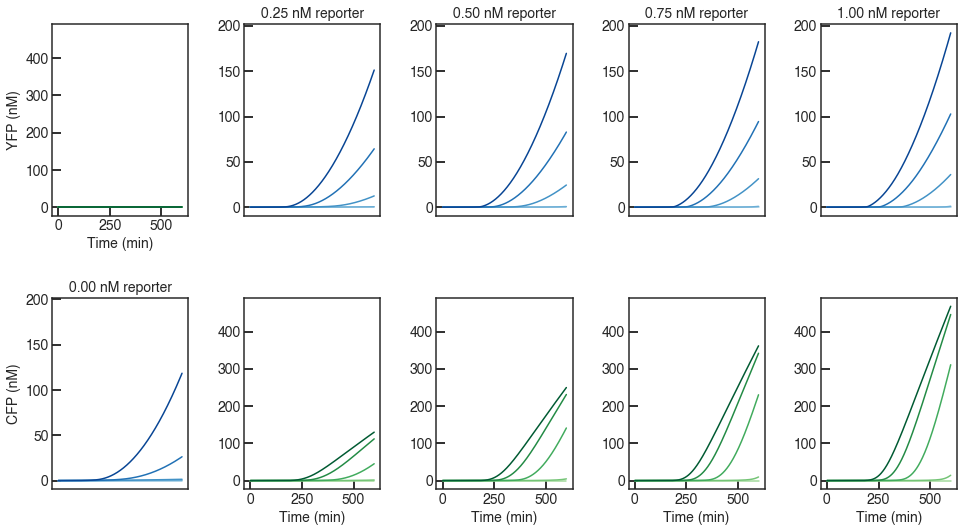

In [18]:
timepoints = np.linspace(0,600,600)
simdata = {}
int_levels = [0,0.25,0.5,0.75,1.]
# int_levels = [0.5,1.]
num_integrase_conditions = len(int_levels)
rep_levels = [0,0.25,0.5,0.75,1.]
# rep_levels = [0.5,1.]
num_reporter_conditions = len(rep_levels)
for int_nm in int_levels:
    for rep_nm in rep_levels:
        m.set_species({"G_I": int_nm, "U": rep_nm})
        simulation_result = py_simulate_model(Model = m, timepoints = timepoints)
        simdata[(int_nm,rep_nm,'cfp')] = simulation_result['Int']
        simdata[(int_nm,rep_nm,'yfp')] = simulation_result['YFP']

## Plot the results:
colorc = ['#9ecae1','#6baed6','#4292c6', '#2171b5','#084594']
colory = ['#a1d99b','#74c476','#41ab5d','#238b45','#005a32']
# colorc = ['#2171b5','#084594']
# colory = ['#238b45','#005a32']
# time_lim = (0,240)
# cfp_lim = (0,250)
# yfp_lim = (0,70)
figsize = (14,8)
# figsize = (5,5)

fig = plt.figure(figsize=figsize)
index = 1
for rep_ind in range(num_reporter_conditions):

    if index == 1:
#         axc = fig.add_subplot(2,num_integrase_conditions,index)
        axc = fig.add_subplot(2,num_reporter_conditions,index+5)
        axy = fig.add_subplot(2,num_reporter_conditions,index)

    else:
        axc = fig.add_subplot(2,num_integrase_conditions,index, sharey = axc)
        axy = fig.add_subplot(2,num_reporter_conditions,index+5, sharey = axy)
#         axy = fig.add_subplot(2,num_reporter_conditions,index+2, sharey = axy)

    for int_ind in range(num_integrase_conditions):
        axc.plot(timepoints, simdata[(int_levels[int_ind] ,rep_levels[rep_ind],'cfp')],
                 color=colorc[int_ind] )
        axy.plot(timepoints, simdata[(int_levels[int_ind] ,rep_levels[rep_ind],'yfp')]
                 ,color=colory[int_ind])
    
    axc.set_title('%1.2f nM reporter' % (rep_levels[rep_ind]))
#     axc.set_xlim(time_lim)
#     axy.set_xlim(time_lim)
#     axc.set_ylim(cfp_lim)
#     axy.set_ylim((0,40))

    axy.set_xlabel('Time (min)')
    
    if index == 1:
        axc.set_ylabel('CFP (nM)')
        axy.set_ylabel('YFP (nM)')
#         axc.legend(['0 nM integrase plasmid', '0.25 nM integrase plasmid',
#                     '0.50 nM integrase plasmid', '0.75 nM integrase plasmid',
#                     '1.00 nM integrase plasmid'], bbox_to_anchor = (1,0,0,0),
#                    loc='best')
#         axy.legend(['0 nM reporter plasmid', '0.25 nM reporter plasmid',
#                     '0.50 nM reporter plasmid', '0.75 nM reporter plasmid',
#                     '1.00 nM reporter plasmid'], bbox_to_anchor = (1,0,0,0),
#                    loc='best')
#     else:
#         axc.set_yticks([])
#         axy.set_yticks([])
    axc.set_xticks([])

    index += 1
    
fig.tight_layout()
# fig.savefig('integrase-full-simulation.svg')
# fig.savefig('integrase-full-simulation-only2.svg')

## Sensitivity analysis of the full model

In [19]:
m.get_parameter_dictionary()

{'k_bpi': 100.0,
 'k_upi': 1.0,
 'k_txi': 0.25,
 'k_bri': 100.0,
 'k_uri': 1.0,
 'k_tli': 0.013,
 'a_i': 10.0,
 'd_i': 1.0,
 'k_int': 0.1,
 'a_r': 0.033,
 'd_r': 0.5,
 'k_bp': 80.0,
 'k_up': 2.0,
 'k_tx': 0.4,
 'k_br': 80.0,
 'k_ur': 2.0,
 'k_tl': 0.05,
 'd_bTi': 20.0,
 'd_uTi': 2.0,
 'd_Ti': 0.005,
 'd_bRTi': 20.0,
 'd_uRTi': 2.0,
 'd_RTi': 0.005,
 'd_bT': 10.0,
 'd_uT': 2.0,
 'd_T': 0.001,
 'd_bRT': 10.0,
 'd_uRT': 2.0,
 'd_RT': 0.005}

In [20]:
m.get_species_dictionary()

{'G_I': 1.0,
 'P': 200.0,
 'T_I': 0.0,
 'CI_1': 0.0,
 'R': 400.0,
 'Int': 0.0,
 'CI_2': 0.0,
 'U': 1.0,
 'A': 0.0,
 'C_I': 0.0,
 'C_A': 0.0,
 'T': 0.0,
 'C_1': 0.0,
 'YFP': 0.0,
 'C_2': 0.0,
 'Endo': 30.0,
 'C_ETi': 0.0,
 'C_ERTi': 0.0,
 'C_E': 0.0,
 'C_ER': 0.0}

C:\Users\apand\AppData\Roaming\Python\Python37\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\apand\AppData\Local\Continuum\anaconda3\lib\site-packages\bioscrape\analysis.py:227: RuntimeWarning: invalid value encountered in true_divide
  SSM_normalized[:,j,i] = np.divide(SSM[:,j,i]*params_values[j], solutions[:,i])


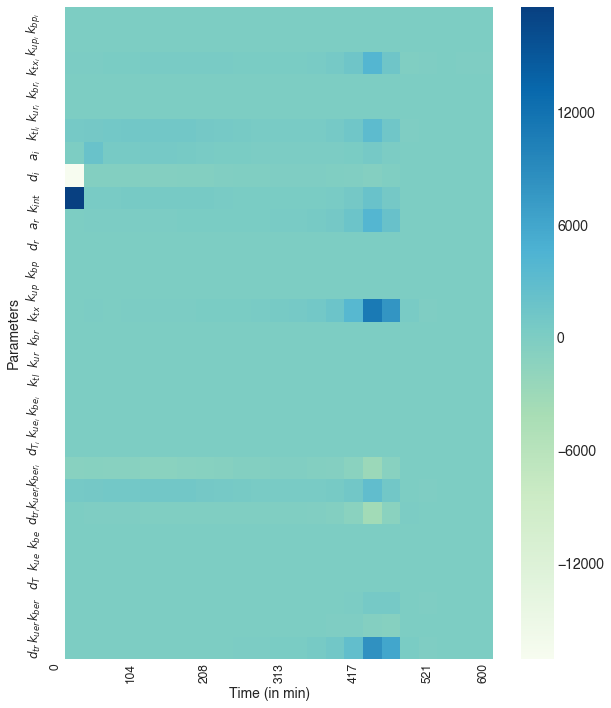

In [8]:
from bioscrape.analysis import py_sensitivity_analysis
import seaborn as sn
int_levels = [0.5]
rep_levels = [0.5]
# int_levels = [0.25,0.5,0.75,1.]
# rep_levels = [0.25,0.5,0.75,1.]
timepoints = np.linspace(0,600,24, endpoint = True)
figsize = (10,12)
fig, ax = plt.subplots(nrows = len(int_levels), ncols= len(rep_levels), figsize=figsize)
index = 1
params_names_latex = ['$k_{bp_i}$', '$k_{up_i}$', '$k_{tx_i}$', '$k_{br_i}$', '$k_{ur_i}$', '$k_{tl_i}$',
                      '$a_i$','$d_i$', '$k_{int}$', '$a_r$','$d_r$', '$k_{bp}$', '$k_{up}$', '$k_{tx}$', 
                      '$k_{br}$', '$k_{ur}$', '$k_{tl}$','$k_{be_i}$', '$k_{ue_i}$', '$d_{T_i}$', '$k_{ber_i}$', '$k_{uer_i}$',
                      '$d_{tr_i}$','$k_{be}$', '$k_{ue}$', '$d_{T}$', '$k_{ber}$', '$k_{uer}$',
                      '$d_{tr}$']
for rep_ind in range(len(rep_levels)):
    rep_nm = rep_levels[rep_ind]
#     axc = fig.add_subplot(2,2,index)
#     axy = fig.add_subplot(2,2,index+2)
    for int_ind in range(len(int_levels)):
        int_nm = int_levels[int_ind]
        m.set_species({"G_I": int_nm, "U": rep_nm})
        SSM = py_sensitivity_analysis(m, timepoints, normalize = True)
        sn_ax = sn.heatmap(SSM[:,:,13].T, ax = ax, cmap = 'GnBu', 
                           xticklabels = np.linspace(timepoints[0],timepoints[-1], len(timepoints),
                                                     endpoint = True,dtype = 'int'))
#         sn.heatmap(SSM[:,:,6].T, ax = ax[rep_ind][int_ind])
#         ax.set_title('Integrase plasmid:{0}, Reporter Plasmid:{1}'.format(int_nm, rep_nm))
#     if index == 1:
#         axc.set_yticklabels(m.get_param_list())
#         axy.set_yticklabels(m.get_param_list())
#     else:
#         axc.set_yticklabels([])
#         axy.set_yticklabels([])
#     axc.set_xticklabels(np.arange(0,600))
#     axy.set_xticklabels(np.round(timepoints,1))
#     ax.set_xlabel('Time')
#     ax.set_ylabel('Parameters')
    index += 1
sn_ax.figure.axes[-1].xaxis.label.set_size(20)
ax = fig.axes
_ = plt.xlabel('Time (in min)', fontsize = 14)
_ = plt.ylabel('Parameters', fontsize = 14)
# plt.locator_params(axis='x', nbins=15)
_ = ax[0].tick_params(axis='x', which='major', labelsize=12, bottom = False)
_ = ax[0].tick_params(axis='y', which='major', labelsize=12, left = False)
_ = ax[0].set_yticklabels(params_names_latex)
every_nth = 4
for n, label in enumerate(ax[0].xaxis.get_ticklabels()):
    if n == len(timepoints)-1:
        continue
    if n % every_nth != 0:
        label.set_visible(False)
_ = ax[1].tick_params(axis = 'x', labelsize = 18)
# bottom, top = ax[0].get_ylim()
# ax[0].set_ylim(bottom + 0.5, top - 0.5)# h.set_rotation(0)
# _ = plt.savefig('integrase-sensitivity-25-25.svg')
plt.show()

# From CRNs to ODEs -- Model Reduction

With the above CRN, we can simulate the system dynamics as shown. Underlying the simulations, is an ordinary differential equation (ODE) that is integrated to generate the solutions for the system with time. For the CRN above, we have mass-action propensity reactions that are written into an SBML file with the corresponding reaction rate parameters. These are then integrated as ODEs by the simulator (bioscrape). The number of species in the CRN is equal to the number of state variables in the ODE. It is often the case that the values for the different reaction rate parameters are unknown and hard to infer because of limited number of measurments. Hence, we derive reduced-order ODE models with fewer number of parameters to improve our estimates of the "lumped" parameters given the measurements.


### The AutoReduce package can automatically compute reduced-order ODE models for biological system model in an SBML file.



## AutoReduce notation

The following notation would be helpful in setting up the model reduction problem. Let us assume that the state variables in the ODE model are called $x$, then we can write the dynamics of the system as:

$ \dot{x} = f(x, \theta)$

where $f(\cdot)$ is a nonlinear vector function that models the dynamics of the state variables $x$. The output variables of the system may be modeled as:

$ y = Cx$ 

where $y$ is the output vector and $C$ is the output matrix. Note that the shape of the $C$ matrix will be length of $y$ times the length of of $x$. 

With AutoReduce, we consider quasi-steady state approximations to derive reduced models. All reduced-order models are denoted by a $\hat{\cdot}$ to the variables. For example, $\hat{x}$ is the states of the reduced-order model. These are the so-called "slow states" of the model since we are interested in the dynamics of these states and we assume that the dynamics of the remaining states $x_c$ have been collapsed to algebraic relationships. The states $x_c$ are called the "fast states" since we assume these to be at quasi-steady state.

Note that with AutoReduce, all reduced models preserve the structure of the full model since transformations are not introduced in the model reduction procedure. 

# Model Reduction with AutoReduce

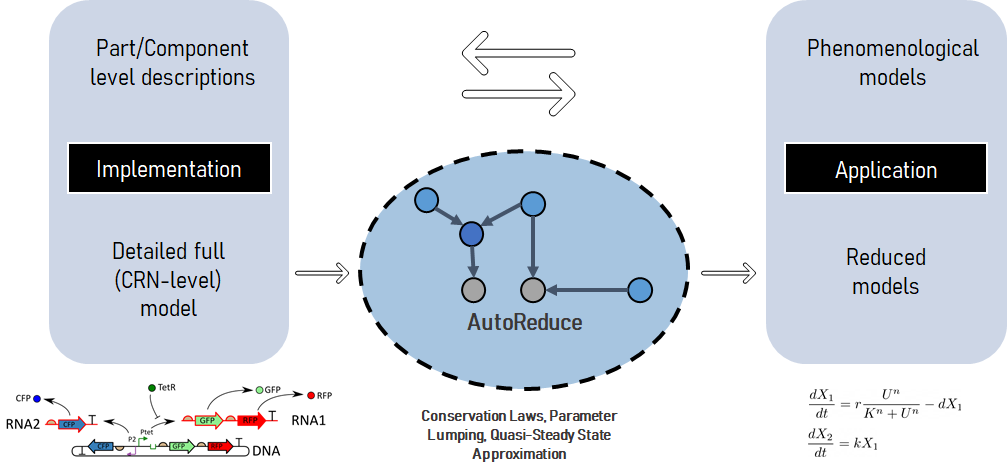

To get started with AutoReduce, we load a model using an SBML file:

In [48]:
from autoreduce.converters import load_sbml
from autoreduce.system import System
from sympy import Symbol
import sympy

integrase_system_context = load_sbml('integrase_txtl_resources_updated.xml', 
                                                 outputs = ['Int', 'YFP'])

In [49]:
integrase_system_context.params_values = list(parameter_dict.values())

In [50]:
integrase_system_context.params_values

[0.24, 0.03, 100, 0.05, 0.01, 0.001, 15]

Total: 20 states.

In [51]:
G_I, P,T_I, CI_1, R, Int, CI_2, U, A, C_I, C_A, T, C_1, YFP, C_2, Endo, C_ETi, C_ERTi, C_E, C_ER = integrase_system_context.x

## Model Reduction: Step 1 - Conservation Laws

For all binding and catalysis steps, we can usually derive conservation laws from the ODE of a CRN. To derive the reduced model on applying conservation laws, we simply need to call the `set_conservation_laws` function for the AutoReduce `System` object. To run this function, we need to define what the conserved quantities are and the states that we need to eliminate after we set the conservation laws to the model. We do this for the integrase_system example above where $R + C = R_{tot}$.

We can further simplify the above CRN to represent the measurements that we have for integrase and flipped plasmid (CFP and YFP respectively).

Let R = unactivated reporter plasmid = attB--attP plasmid. So we can write:

$ \varnothing \rightarrow I $

$4 I + R \rightleftharpoons C$

$C \rightarrow C_A$

$ C_A \rightleftharpoons A + 4I$

$ A \rightarrow Y + A$



In [52]:
crn_matrix = sympy.Matrix(integrase_system_context.f)

In [53]:
sympy.Matrix(integrase_system_context.x)

Matrix([
[   G_I],
[     P],
[   T_I],
[  CI_1],
[     R],
[   Int],
[  CI_2],
[     U],
[     A],
[   C_I],
[   C_A],
[     T],
[   C_1],
[   YFP],
[   C_2],
[  Endo],
[ C_ETi],
[C_ERTi],
[   C_E],
[  C_ER]])

In [54]:
crn_matrix

Matrix([
[                                                                                                                                    CI_1*k_txi + CI_1*k_upi - G_I*P*k_bpi],
[                                                                                                  -A*P*k_bp + CI_1*k_txi + CI_1*k_upi + C_1*k_tx + C_1*k_up - G_I*P*k_bpi],
[                                                                                        CI_1*k_txi + CI_2*k_tli + CI_2*k_uri + C_ETi*d_uTi - Endo*T_I*d_bTi - R*T_I*k_bri],
[                                                                                                                                   -CI_1*k_txi - CI_1*k_upi + G_I*P*k_bpi],
[                                                                        CI_2*k_tli + CI_2*k_uri + C_2*k_tl + C_2*k_ur + C_ER*d_RT + C_ERTi*d_RTi - R*T*k_br - R*T_I*k_bri],
[                                                                                            -2.0*A*Int**2*d_r + CI_2*k_tli + 

In [55]:
total_quantities = {'Gi_tot':0, 'P_tot':0, 'R_tot':0, 'G_tot':0, 'E_tot':0}
num_conservation_laws = 5
states_to_eliminate = [G_I, P, R, U, Endo]
conserved_system_context = integrase_system_context.solve_conservation_laws(num_conservation_laws = num_conservation_laws,
                                                                            total_quantities = total_quantities,
                                                                            states_to_eliminate = states_to_eliminate)

Found conservation laws: [CI_1 + G_I - Gi_tot, CI_1 + C_1 + P - P_tot, CI_2 + C_2 + C_ER + C_ERTi + R - R_tot, A + C_1 + C_A + C_I - G_tot + U, C_E + C_ER + C_ERTi + C_ETi - E_tot + Endo]


In [56]:
conserved_system_context.conservation_laws

[CI_1 + G_I - Gi_tot,
 CI_1 + C_1 + P - P_tot,
 CI_2 + C_2 + C_ER + C_ERTi + R - R_tot,
 A + C_1 + C_A + C_I - G_tot + U,
 C_E + C_ER + C_ERTi + C_ETi - E_tot + Endo]

In [57]:
sympy.Matrix(integrase_system_context.x)

Matrix([
[   T_I],
[  CI_1],
[   Int],
[  CI_2],
[     A],
[   C_I],
[   C_A],
[     T],
[   C_1],
[   YFP],
[   C_2],
[ C_ETi],
[C_ERTi],
[   C_E],
[  C_ER]])

In [58]:
sympy.Matrix(integrase_system_context.f)[2]

-2.0*A*Int**2*d_r + CI_2*k_tli + 2.0*C_A*a_r + 2.0*C_I*d_i - 2.0*Int**2*a_i*(-A - C_1 - C_A - C_I + G_tot)

Total: 15 states.

## Simulation (with conservation laws)

In [75]:
from autoreduce.utils import get_ODE
import numpy as np
timepoints = np.linspace(0,600,600)
ode_reduced = get_ODE(integrase_system_context, timepoints=timepoints)

In [76]:
RNAP_total = 200
Ribosome_total = 400
Endonuclease_total = 30
ode_reduced.params_values = list(parameter_dict.values()) + [0, RNAP_total, Ribosome_total, 0, Endonuclease_total]

In [77]:
simdata = {}
int_levels = [0.5,1.]
rep_levels = [0.5,1.]
# Set R_tot and I_pl with these lists. 
for int_nm in int_levels:
    for rep_nm in rep_levels:
        ode_reduced.params_values[-5] = int_nm #Gi_tot
        ode_reduced.params_values[-2] = rep_nm # G_tot
        simulation_result = ode_reduced.solve_system().T
        simdata[(int_nm,rep_nm,'cfp')] = simulation_result[2,:]
        simdata[(int_nm,rep_nm,'yfp')] = simulation_result[9,:]

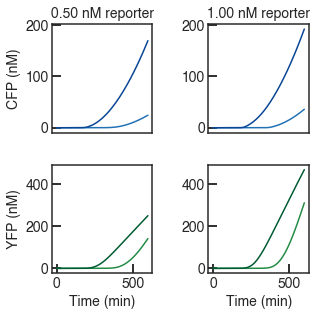

In [78]:
colorc = ['#2171b5','#084594']
colory = ['#238b45','#005a32']
# time_lim = (0,180)
# cfp_lim = (0,250)
# yfp_lim = (0,70)
figsize = (5,5)
fig = plt.figure(figsize=figsize)
index = 1
num_integrase_conditions = len(int_levels)
num_reporter_conditions = len(rep_levels)

for rep_ind in range(num_integrase_conditions):
    if index == 1:
        axc = fig.add_subplot(2,num_integrase_conditions,index)
        axy = fig.add_subplot(2,num_reporter_conditions,index+2)
    else:
        axc = fig.add_subplot(2,num_integrase_conditions,index, sharey = axc)
        axy = fig.add_subplot(2,num_reporter_conditions,index+2, sharey = axy)
        
    for int_ind in range(len(rep_levels)):
        axc.plot(timepoints, simdata[(int_levels[int_ind] ,rep_levels[rep_ind],'cfp')],
                 color=colorc[int_ind] )
        axy.plot(timepoints, simdata[(int_levels[int_ind] ,rep_levels[rep_ind],'yfp')]
                 ,color=colory[int_ind])
    
    axc.set_title('%1.2f nM reporter' % (rep_levels[rep_ind]))
#     axc.set_xlim(time_lim)
#     axy.set_xlim(time_lim)
#     axc.set_ylim(cfp_lim)
#     axy.set_ylim((0,40))

    axy.set_xlabel('Time (min)')
    
    if index == 1:
        axc.set_ylabel('CFP (nM)')
        axy.set_ylabel('YFP (nM)')
#         axc.legend(['0.5 nM integrase plasmid',
#                     '1.00 nM integrase plasmid'], bbox_to_anchor = (1,0,0,0),
#                    loc='best')
#         axy.legend(['0.50 nM reporter plasmid',
#                     '1.00 nM reporter plasmid'], bbox_to_anchor = (1,0,0,0),
#                    loc='best')
#     else:
#         axc.set_yticks([])
#         axy.set_yticks([])
    axc.set_xticks([])

    index += 1
fig.tight_layout()
# fig.savefig('integrase-conserved-model.svg')

In [79]:
integrase_system_context.write_sbml('integrase_system_context_conserved.xml')

<SBMLDocument>

## Model Reduction: Step 2 - Time-Scale Separation

To further reduce the system model, we can use quasi-steady state approximation (QSSA) assumptions. The common practice is to assume certain states at quasi-steady state and derive the resulting reduced models by hand. However, AutoReduce automates the QSSA procedure so that it is possible to verify whether given assumptions of QSSA are valid or not. The automated QSSA also allows us to compute different reduced models and compare them in different parameter regimes. 

In [26]:
# Assume CI_2 (complex_protein_Ribo_rna_T_int_) at QSS
reduced_model, collapsed_model = integrase_system_context.solve_timescale_separation(slow_states = [T_I, CI_1, Int, 
                                                                                                    CI_2, A, 
                                                                                                    C_A, T, 
                                                                                                    YFP, C_1, C_2, C_ETi, 
                                                                                                    C_ERTi, C_E, C_ER])

c:\users\apand\box\biocircuits\ayush\synbio\autoreduce\autoreduce\model_reduction.py:928: SymPyDeprecationWarning: 

Eq(expr) with a single argument with the right-hand side
defaulting to 0 is deprecated. Use Eq(expr, 0) instead.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-eq-expr
for details.

This has been deprecated since SymPy version 1.5. It
will be removed in a future version of SymPy.

  x_c_sub = solve(Eq(f_c[i]), x_c[i])


Successful time-scale separation solution obtained with states: [T_I, CI_1, Int, CI_2, A, C_A, T, YFP, C_1, C_2, C_ETi, C_ERTi, C_E, C_ER]!


In [38]:
sympy.Matrix(reduced_model.f)

Matrix([
[                                                                               CI_1*k_txi + CI_2*k_tli + CI_2*k_uri + C_ETi*d_uTi + T_I*d_bTi*(C_E + C_ER + C_ERTi + C_ETi - E_tot) + T_I*k_bri*(CI_2 + C_2 + C_ER + C_ERTi - R_tot)],
[                                                                                                                                                               -CI_1*k_txi - CI_1*k_upi + k_bpi*(CI_1 - Gi_tot)*(CI_1 + C_1 - P_tot)],
[(-4.0*a_i*d_i*(A + C_1 + C_A - G_tot)*pow(Int, 4) + 4.0*a_i*(d_i + k_int)*(A + C_1 + C_A - G_tot)*pow(Int, 4) + (a_i*pow(Int, 4) + d_i + k_int)*(-4.0*A*d_r*pow(Int, 4) + CI_2*k_tli + 4.0*C_A*a_r))/(a_i*pow(Int, 4) + d_i + k_int)],
[                                                                                        CI_2*d_bRTi*(C_E + C_ER + C_ERTi + C_ETi - E_tot) - CI_2*k_tli - CI_2*k_uri + C_ERTi*d_uRTi - T_I*k_bri*(CI_2 + C_2 + C_ER + C_ERTi - R_tot)],
[                                                              

In [39]:
# Uncomment if you want to try to reduce further 
# T_I, CI_1, Int, A, C_A, T, C_1, YFP, C_2, C_ETi, C_ERTi, C_E works
from autoreduce.utils import get_reducible
reduce_reduced_model = get_reducible(reduced_model)
# Assume C_I (complex_dna_attP_attB_protein_Int_4x_) 
# and then C_ER (complex_complex_protein_Ribo_rna_T_A__protein_RNAase_) also at QSS 
reduced_model, collapsed_model = reduce_reduced_model.solve_timescale_separation(slow_states = [CI_1, Int, 
                                                                                                CI_2, A,
                                                                                                YFP,C_1, C_2, C_ETi, 
                                                                                                C_ERTi, C_E, C_ER])

Successful time-scale separation solution obtained with states: [CI_1, Int, CI_2, A, YFP, C_1, C_2, C_ETi, C_ERTi, C_E, C_ER]!


In [40]:
len(reduced_model.x)

11

In [41]:
from autoreduce.utils import get_ODE

timepoints = np.linspace(0,600,600)
ode_reduced = get_ODE(reduced_model, timepoints=timepoints)
RNAP_total = 200
Ribosome_total = 400
Endonuclease_total = 30
ode_reduced.params_values = list(parameter_dict.values()) + [0, RNAP_total, Ribosome_total, 0, Endonuclease_total]

In [42]:
simdata = {}
int_levels = [0.5,1.]
rep_levels = [0.5,1.]
# Set R_tot and I_pl with these lists. 
for int_nm in int_levels:
    for rep_nm in rep_levels:
        ode_reduced.params_values[-5] = int_nm #Gi_tot
        ode_reduced.params_values[-2] = rep_nm # G_tot
        simulation_result = ode_reduced.solve_system().T
        simdata[(int_nm,rep_nm,'cfp')] = simulation_result[1,:]
        simdata[(int_nm,rep_nm,'yfp')] = simulation_result[4,:]

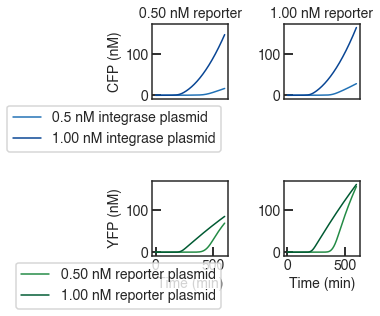

In [44]:
colorc = ['#2171b5','#084594']
colory = ['#238b45','#005a32']
# time_lim = (0,180)
# cfp_lim = (0,250)
# yfp_lim = (0,70)
figsize = (5,5)
fig = plt.figure(figsize=figsize)
index = 1
num_integrase_conditions = len(int_levels)
num_reporter_conditions = len(rep_levels)

for rep_ind in range(num_integrase_conditions):
    if index == 1:
        axc = fig.add_subplot(2,num_integrase_conditions,index)
        axy = fig.add_subplot(2,num_reporter_conditions,index+2)
    else:
        axc = fig.add_subplot(2,num_integrase_conditions,index, sharey = axc)
        axy = fig.add_subplot(2,num_reporter_conditions,index+2, sharey = axy)
        
    for int_ind in range(len(rep_levels)):
        axc.plot(timepoints, simdata[(int_levels[int_ind] ,rep_levels[rep_ind],'cfp')],
                 color=colorc[int_ind] )
        axy.plot(timepoints, simdata[(int_levels[int_ind] ,rep_levels[rep_ind],'yfp')]
                 ,color=colory[int_ind])
    
    axc.set_title('%1.2f nM reporter' % (rep_levels[rep_ind]))
#     axc.set_xlim(time_lim)
#     axy.set_xlim(time_lim)
#     axc.set_ylim(cfp_lim)
#     axy.set_ylim((0,40))

    axy.set_xlabel('Time (min)')
    
    if index == 1:
        axc.set_ylabel('CFP (nM)')
        axy.set_ylabel('YFP (nM)')
        axc.legend(['0.5 nM integrase plasmid',
                    '1.00 nM integrase plasmid'], bbox_to_anchor = (1,0,0,0),
                   loc='best')
        axy.legend(['0.50 nM reporter plasmid',
                    '1.00 nM reporter plasmid'], bbox_to_anchor = (1,0,0,0),
                   loc='best')
#     else:
#         axc.set_yticks([])
#         axy.set_yticks([])
    axc.set_xticks([])

    index += 1
fig.tight_layout()
# fig.savefig('integrase-11state-model.svg')

#### Further assumptions:

If RNAP is abundant:
P_tot - CI_1 ~= P_tot

If Ribosome is abundant:
R_tot - CI_2 ~= R_tot

In [45]:
reduced_model.params[-3]

R_tot

In [46]:
updated_f = []
for fi in reduced_model.f:
    temp_fi = fi.subs(C_1 - reduced_model.params[-4], -reduced_model.params[-4])
    temp_fi = temp_fi.subs(CI_1 - reduced_model.params[-4], -reduced_model.params[-4])
    temp_fi = temp_fi.subs(C_2 - reduced_model.params[-3], -reduced_model.params[-3])
    updated_fi = temp_fi.subs(CI_2 - reduced_model.params[-3], -reduced_model.params[-3])
    updated_f.append(updated_fi)
reduced_model.f = updated_f

In [47]:
sympy.Matrix(reduced_model.f)

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                            -CI_1*k_txi - CI_1*k_upi - P_tot*k_bpi*(CI_1 - Gi_tot)],
[                                                                                                                                                                                                                                                                                                                                                                                                                                                        CI_2*k_tli],
[(k_bri*(C_ER + C_ERTi - R_tot)*(CI_1*k_txi + CI_2*k_tli + CI_2*k_uri + C_ETi*d_uTi

In [48]:
reduce_reduced_model = get_reducible(reduced_model)
reduced_model, collapsed_model = reduce_reduced_model.solve_timescale_separation(slow_states = [Int, 
                                                                                                CI_2, A,
                                                                                                YFP,C_1, C_2, C_ETi, 
                                                                                                C_ERTi, C_E, C_ER])

Successful time-scale separation solution obtained with states: [Int, CI_2, A, YFP, C_1, C_2, C_ETi, C_ERTi, C_E, C_ER]!


In [49]:
sympy.Matrix(reduced_model.f)

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    CI_2*k_tli],
[(k_bri*(Gi_tot*P_tot*k_bpi*k_txi + (CI_2*k_tli + CI_2*k_uri + C_ETi*d_uTi)*(P_tot*k_bpi + k_txi + k_upi))*(C_ER + C_ERTi - R_tot) + (P_tot*k_bpi + k_txi + k_upi)*(CI_2*d_bRTi*(C_E + C_ER + C_ERTi + C_ETi - E_tot) - CI_2*k_tli - CI_2*k_uri + C_ERTi*d_uRTi)*(CI_2*k_bri + C_2*k_bri + C_E*d_bTi + C_ER*d_bTi + C_ER*k_bri + C_ERTi*d_bTi + C_ERTi*k_bri + C_ETi*d_bTi - E_tot*d_bTi - R_tot*k_bri))/((P_tot*k_bpi + k_txi + k_upi)*(CI_2

In [50]:
reduce_reduced_model = get_reducible(reduced_model)
reduced_model, collapsed_model = reduce_reduced_model.solve_timescale_separation(slow_states = [Int, 
                                                                                                CI_2, A,
                                                                                                YFP,C_2, C_ETi, 
                                                                                                C_ERTi, C_E, C_ER])

Successful time-scale separation solution obtained with states: [Int, CI_2, A, YFP, C_2, C_ETi, C_ERTi, C_E, C_ER]!


In [51]:
sympy.Matrix(reduced_model.f)

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    CI_2*k_tli],
[(k_bri*(Gi_tot*P_tot*k_bpi*k_txi + (CI_2*k_tli + CI_2*k_uri + C_ETi*d_uTi)*(P_tot*k_bpi + k_txi + k_upi))*(C_ER + C_ERTi - R_tot) + (P_tot*k_bpi + k_txi + k_upi)*(CI_2*d_bRTi*(C_E + C_ER + C_ERTi + C_ETi - E_tot) - CI_2*k_tli - CI_2*k_uri + C_ERTi*d_uRTi)*(CI_2*k_bri + C_2*k_bri + C_E*d_bTi + C_ER*d_bTi + C_ER*k_bri + C_ERTi*d_bTi + C_ERTi*k_bri + C_ETi*d_bTi - E_tot*d_bTi - R_tot*k_bri))/((P_tot*k_bpi + k_txi + k_upi)*(CI_2

In [52]:
updated_f = []
for fi in reduced_model.f:
    updated_fi = fi.subs(C_ERTi - reduced_model.params[-1], -reduced_model.params[-1])
    updated_f.append(updated_fi)
reduced_model.f = updated_f

In [53]:
reduce_reduced_model = get_reducible(reduced_model)
reduced_model, collapsed_model = reduce_reduced_model.solve_timescale_separation(slow_states = [Int, 
                                                                                                CI_2, A,
                                                                                                YFP,C_2, C_ETi, 
                                                                                                C_E, C_ER])

Successful time-scale separation solution obtained with states: [Int, CI_2, A, YFP, C_2, C_ETi, C_E, C_ER]!


In [54]:
sympy.Matrix(reduced_model.x)

Matrix([
[  Int],
[ CI_2],
[    A],
[  YFP],
[  C_2],
[C_ETi],
[  C_E],
[ C_ER]])

In [55]:
from autoreduce.utils import get_ODE

timepoints = np.linspace(0,600,600)
ode_reduced = get_ODE(reduced_model, timepoints=timepoints)
RNAP_total = 100
Ribosome_total = 100
Endonuclease_total = 8
ode_reduced.params_values = list(parameter_dict.values()) + [0, RNAP_total, Ribosome_total, 0, Endonuclease_total]

In [56]:
ode_reduced.params[-2]

G_tot

In [57]:
simdata = {}
int_levels = [0.5,1.]
rep_levels = [0.5,1.]
# Set R_tot and I_pl with these lists. 
for int_nm in int_levels:
    for rep_nm in rep_levels:
        ode_reduced.params_values[-5] = int_nm #Gi_tot
        ode_reduced.params_values[-2] = rep_nm # G_tot
        simulation_result = ode_reduced.solve_system().T
        simdata[(int_nm,rep_nm,'cfp')] = simulation_result[0,:]
        simdata[(int_nm,rep_nm,'yfp')] = simulation_result[3,:]

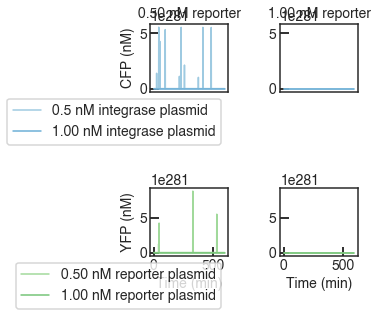

In [58]:
colorc = ['#9ecae1','#6baed6','#4292c6', '#2171b5','#084594']
colory = ['#a1d99b','#74c476','#41ab5d','#238b45','#005a32']
# time_lim = (0,180)
# cfp_lim = (0,250)
# yfp_lim = (0,70)
figsize = (5,5)
fig = plt.figure(figsize=figsize)
index = 1
num_integrase_conditions = len(int_levels)
num_reporter_conditions = len(rep_levels)

for rep_ind in range(num_integrase_conditions):
    if index == 1:
        axc = fig.add_subplot(2,num_integrase_conditions,index)
        axy = fig.add_subplot(2,num_reporter_conditions,index+2)
    else:
        axc = fig.add_subplot(2,num_integrase_conditions,index, sharey = axc)
        axy = fig.add_subplot(2,num_reporter_conditions,index+2, sharey = axy)
        
    for int_ind in range(len(rep_levels)):
        axc.plot(timepoints, simdata[(int_levels[int_ind] ,rep_levels[rep_ind],'cfp')],
                 color=colorc[int_ind] )
        axy.plot(timepoints, simdata[(int_levels[int_ind] ,rep_levels[rep_ind],'yfp')]
                 ,color=colory[int_ind])
    
    axc.set_title('%1.2f nM reporter' % (rep_levels[rep_ind]))
#     axc.set_xlim(time_lim)
#     axy.set_xlim(time_lim)
#     axc.set_ylim(cfp_lim)
#     axy.set_ylim((0,40))

    axy.set_xlabel('Time (min)')
    
    if index == 1:
        axc.set_ylabel('CFP (nM)')
        axy.set_ylabel('YFP (nM)')
        axc.legend(['0.5 nM integrase plasmid',
                    '1.00 nM integrase plasmid'], bbox_to_anchor = (1,0,0,0),
                   loc='best')
        axy.legend(['0.50 nM reporter plasmid',
                    '1.00 nM reporter plasmid'], bbox_to_anchor = (1,0,0,0),
                   loc='best')
#     else:
#         axc.set_yticks([])
#         axy.set_yticks([])
    axc.set_xticks([])

    index += 1
fig.tight_layout()
# fig.savefig('integrase-8state-model.svg')

Does not work.

## Model without context

In [37]:
parameters_simple = {("gene_expression", "P_int", "kexpress"):1,
                     ("gene_expression", "P_A", "kexpress"):1}
# Integrase binding to DNA
a_i = ParameterEntry("a_i", 30)
# Integrase unbinding DNA
d_i = ParameterEntry("d_i", 0.01)

# Integrase flipping rate
k_int = ParameterEntry("k_int", 0.1)

# Integrase-attL_attR complex unbinding to form attL_attR and Integrase
a_r = ParameterEntry("a_r", 10)
# Binding of attL_attR and I to form Integrase-attL_attR complex 
d_r = ParameterEntry("d_r", 0.01)

parameters_integrase = {'a_i':a_i, 'd_i':d_i, 'k_int':k_int, 'a_r':a_r, 'd_r':d_r}

G_int = DNAassembly("G_int", promoter = "P_int", rbs = "RBS1", transcript = "T_int", protein = "Int")
G = DNAassembly("attL_attR", promoter = "P_A", rbs = "RBS2", transcript = "T_A", protein = "Y")
U = Species("attP_attB", material_type = "dna")
I0_mech = IntegraseFlipper()
I0 = IntegraseSite(integrase = G_int.protein, curr_dna = U, reversed_dna = G.dna,
                   cooperativity = 1, parameter_dict = parameters_integrase,
                   mechanism = I0_mech)


M = ExpressionExtract("Gene_Expr_Mix", components = [G_int, I0, G], 
                 parameters = parameters_simple)
CRN = M.compile_crn()
CRN.add_species(U)
CRN.write_sbml_file("integrase_sbml.xml")

True

In [38]:
CRN

Species = dna_G_int, protein_Int, dna_attP_attB, dna_attL_attR, complex_dna_attP_attB_protein_Int_, complex_dna_attL_attR_protein_Int_, protein_Y
Reactions = [
	dna[G_int] --> dna[G_int]+protein[Int]
	protein[Int]+dna[attP_attB] <--> complex[dna[attP_attB]:protein[Int]]
	complex[dna[attP_attB]:protein[Int]] --> complex[dna[attL_attR]:protein[Int]]
	complex[dna[attL_attR]:protein[Int]] <--> protein[Int]+dna[attL_attR]
	dna[attL_attR] --> dna[attL_attR]+protein[Y]
]

### Edit SBML to simply names

In [39]:
import libsbml
reader = libsbml.SBMLReader()
document = reader.readSBML('integrase_sbml.xml')
model = document.getModel()

In [40]:
for element in model.getListOfAllElements():
    if type(element) == libsbml.Species:
        print(element.getId())

dna_G_int
protein_Int
dna_attP_attB
dna_attL_attR
complex_dna_attP_attB_protein_Int_
complex_dna_attL_attR_protein_Int_
protein_Y


In [41]:
old_ids = ['dna_G_int',
'protein_Int',
'dna_attP_attB',
'dna_attL_attR',
'complex_dna_attP_attB_protein_Int_',
'complex_dna_attL_attR_protein_Int_',
'protein_Y',
'kexpress_P_int_gene_expression',
'a_i__',
'd_i__',
'k_int__',
'a_r__',
'd_r__',
'kexpress_P_A_gene_expression']

new_ids = ['G_I',
'Int',
'U',
'A',
'C_I',
'C_A',
'YFP',
'k_i',
'a_i',
'd_i',
'k_int',
'a_r',
'd_r',
'k']
renameSIds(document, old_ids, new_ids, debug = True)
writer = libsbml.SBMLWriter()
writer.writeSBML(document, 'integrase_sbml_updated.xml')

True

In [42]:
m = Model(sbml_filename = 'integrase_sbml_updated.xml')

In [43]:
parameter_dict = {'k_i': 0.16,
                  'a_i': 100,
                  'd_i': 1,
                  'k_int': 1,
                  'a_r': 3,
                  'd_r': 0.5,
                  'k': 2}
parameter_dict = {'k_i': 0.24,
 'a_i': 0.03,
 'd_i': 100,
 'k_int': 0.05,
 'a_r': 1e-2,
 'd_r': 1e-3,
 'k': 15}
m.set_params(parameter_dict)

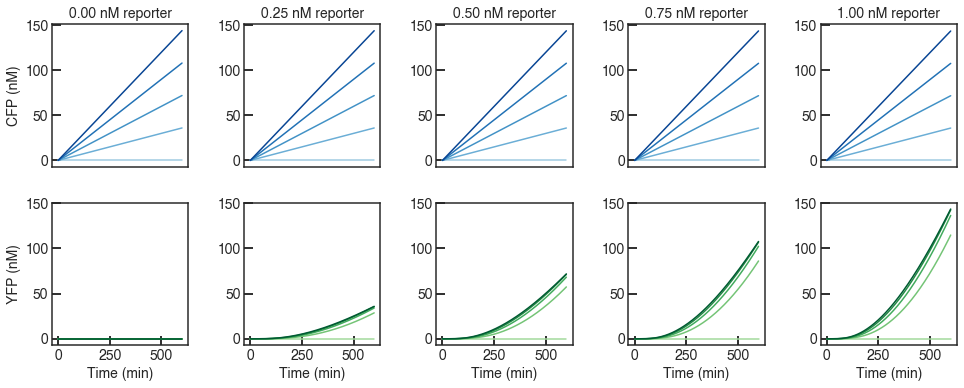

In [44]:
timepoints = np.linspace(0,600,600)
simdata = {}
int_levels = [0,0.25,0.5,0.75,1.]
num_integrase_conditions = len(int_levels)
rep_levels = [0,0.25,0.5,0.75,1.]
num_reporter_conditions = len(rep_levels)
for int_nm in int_levels:
    for rep_nm in rep_levels:
        m.set_species({"G_I": int_nm, "U": rep_nm})
        simulation_result = py_simulate_model(Model = m, timepoints = timepoints)
        simdata[(int_nm,rep_nm,'cfp')] = simulation_result['Int']
        simdata[(int_nm,rep_nm,'yfp')] = simulation_result['YFP']

## Plot the results:
colorc = ['#9ecae1','#6baed6','#4292c6', '#2171b5','#084594']
colory = ['#a1d99b','#74c476','#41ab5d','#238b45','#005a32']
# time_lim = (0,240)
# cfp_lim = (0,250)
# yfp_lim = (0,70)
figsize = (14,6)
fig = plt.figure(figsize=figsize)
index = 1
for rep_ind in range(num_reporter_conditions):

    if index == 1:
        axc = fig.add_subplot(2,num_integrase_conditions,index)
        axy = fig.add_subplot(2,num_reporter_conditions,index+5)
    else:
        axc = fig.add_subplot(2,num_integrase_conditions,index, sharey = axc)
        axy = fig.add_subplot(2,num_reporter_conditions,index+5, sharey = axy)
        
    for int_ind in range(num_integrase_conditions):
        axc.plot(timepoints, simdata[(int_levels[int_ind] ,rep_levels[rep_ind],'cfp')],
                 color=colorc[int_ind] )
        axy.plot(timepoints, simdata[(int_levels[int_ind] ,rep_levels[rep_ind],'yfp')]
                 ,color=colory[int_ind])
    
    axc.set_title('%1.2f nM reporter' % (rep_levels[rep_ind]))
#     axc.set_xlim(time_lim)
#     axy.set_xlim(time_lim)
#     axc.set_ylim(cfp_lim)
#     axy.set_ylim((0,40))

    axy.set_xlabel('Time (min)')
    
    if index == 1:
        axc.set_ylabel('CFP (nM)')
        axy.set_ylabel('YFP (nM)')
#         axc.legend(['0 nM integrase plasmid', '0.25 nM integrase plasmid',
#                     '0.50 nM integrase plasmid', '0.75 nM integrase plasmid',
#                     '1.00 nM integrase plasmid'], bbox_to_anchor = (1,0,0,0),
#                    loc='best')
#         axy.legend(['0 nM reporter plasmid', '0.25 nM reporter plasmid',
#                     '0.50 nM reporter plasmid', '0.75 nM reporter plasmid',
#                     '1.00 nM reporter plasmid'], bbox_to_anchor = (1,0,0,0),
#                    loc='best')
#     else:
#         axc.set_yticks([])
#         axy.set_yticks([])
    axc.set_xticks([])

    index += 1
    
fig.tight_layout()
# fig.savefig('integrase-simple-full-simulation.svg')

In [45]:
m.get_species_dictionary()

{'G_I': 1.0,
 'Int': 0.0,
 'U': 1.0,
 'A': 0.0,
 'C_I': 0.0,
 'C_A': 0.0,
 'YFP': 0.0}

### Sensitivity analysis to assess parameter identifiability

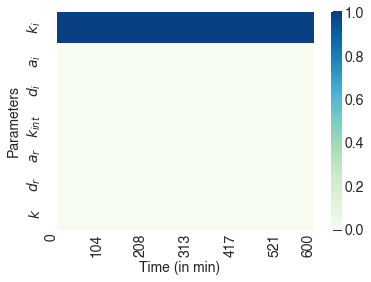

In [47]:
from bioscrape.analysis import py_sensitivity_analysis
import seaborn as sn
int_levels = [0.25]
rep_levels = [0.25]
# int_levels = [0.25,0.5,0.75,1.]
# rep_levels = [0.25,0.5,0.75,1.]
timepoints = np.linspace(0,600,24, endpoint = True)
figsize = (6,4)
fig, ax = plt.subplots(nrows = len(int_levels), ncols= len(rep_levels), figsize=figsize)
index = 1
params_names_latex = ['$k_i$','$a_i$','$d_i$','$k_{int}$','$a_r$','$d_r$','$k$']
for rep_ind in range(len(rep_levels)):
    rep_nm = rep_levels[rep_ind]
    for int_ind in range(len(int_levels)):
        int_nm = int_levels[int_ind]
        m.set_species({"G_I": int_nm, "U": rep_nm})
        SSM = py_sensitivity_analysis(m, timepoints, normalize = True)
        sn_ax = sn.heatmap(SSM[:,:,1].T, ax = ax, cmap = 'GnBu', 
                           xticklabels = np.linspace(timepoints[0],timepoints[-1], len(timepoints),
                                                     endpoint = True,dtype = 'int'))
    index += 1
sn_ax.figure.axes[-1].xaxis.label.set_size(20)
ax = fig.axes
_ = plt.xlabel('Time (in min)', fontsize = 14)
_ = plt.ylabel('Parameters', fontsize = 14)
# plt.locator_params(axis='x', nbins=15)
_ = ax[0].tick_params(axis='x', which='major', labelsize=14, bottom = False)
_ = ax[0].tick_params(axis='y', which='major', labelsize=14, left = False)
_ = ax[0].set_yticklabels(params_names_latex)
every_nth = 4
for n, label in enumerate(ax[0].xaxis.get_ticklabels()):
    if n == len(timepoints)-1:
        continue
    if n % every_nth != 0:
        label.set_visible(False)
_ = ax[1].tick_params(axis = 'x', labelsize = 18)
_ = plt.savefig('simple-integrase-cfp-sensitivity-25-25.svg')
plt.show()

### Model reduction for model without context

In [375]:
from autoreduce.converters import load_sbml
from autoreduce.system import System
from sympy import Symbol
import sympy

integrase_system = load_sbml('integrase_sbml_updated.xml', outputs = ['Int', 'YFP'])
integrase_system.params_values = list(parameter_dict.values())

### The `integrase_system` is the System object of AutoReduce that can be used to derive reduced-order models. We explore this System next:

State Variables:

In [376]:
integrase_system.x

[G_I, Int, U, A, C_I, C_A, YFP]

Nonlinear Dynamics (Symbolic ODE):

In [377]:
integrase_system.f

[0,
 -2.0*A*d_r*pow(Int, 2) + 2.0*C_A*a_r + 2.0*C_I*d_i + G_I*k_i - 2.0*U*a_i*pow(Int, 2),
 C_I*d_i - U*a_i*pow(Int, 2),
 -A*d_r*pow(Int, 2) + C_A*a_r,
 -C_I*d_i - C_I*k_int + U*a_i*pow(Int, 2),
 A*d_r*pow(Int, 2) - C_A*a_r + C_I*k_int,
 A*k]

System Parameters (Symbolic):

In [378]:
integrase_system.params

[k_i, a_i, d_i, k_int, a_r, d_r, k]

Value of Parameters:

In [379]:
integrase_system.params_values

[0.24, 0.03, 100, 0.05, 0.01, 0.001, 15]

Output Matrix for `outputs = ['Int', 'Y']` and `x = [Int, R, C, C_A, A, Y, I_pl]`: 

(Recall that outputs, $y = Cx$ is the notation of our model)

In [380]:
integrase_system.C

array([[0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.]])

Store the state variables as variable names so that we can refer them while reducing the model:

In [381]:
[G_I, Int, U, A, C_I, C_A, YFP] = integrase_system.x

In [382]:
crn_matrix = sympy.Matrix(integrase_system.f)
crn_matrix

Matrix([
[                                                                                   0],
[-2.0*A*d_r*pow(Int, 2) + 2.0*C_A*a_r + 2.0*C_I*d_i + G_I*k_i - 2.0*U*a_i*pow(Int, 2)],
[                                                         C_I*d_i - U*a_i*pow(Int, 2)],
[                                                        -A*d_r*pow(Int, 2) + C_A*a_r],
[                                            -C_I*d_i - C_I*k_int + U*a_i*pow(Int, 2)],
[                                             A*d_r*pow(Int, 2) - C_A*a_r + C_I*k_int],
[                                                                                 A*k]])

In [383]:
from itertools import combinations
# Find the dimension of the nullspace of the stoichiometry matrix
nullspace_dim = 4
all_conserved_sets = []
for d in range(nullspace_dim):
    curr_depth = d + 1
    for i in combinations(crn_matrix, curr_depth):
        sum_terms = 0
        for x in i:
            sum_terms += x
        if sum_terms == 0:
            conserved_species = []
            for x in i:
                for crn_i in range(len(crn_matrix)):
                    if str(crn_matrix[crn_i]) == str(x):
                        conserved_species.append(integrase_system.x[crn_i])
            if len(conserved_species) == 1:
                continue
            all_conserved_sets.append(conserved_species)

In [384]:
all_conserved_sets

[[U, A, C_I, C_A]]

In [385]:
params = integrase_system.params
params_values = integrase_system.params_values
total_quantities = {'G_tot':0}
conserved_quantities = []
for conserved_set, tot in zip(all_conserved_sets, total_quantities.keys()):
    total_symbol = Symbol(tot)
    params.append(total_symbol)
    params_values.append(total_quantities[tot])
    law = 0
    for x in conserved_set:
        law += x
    law += -total_symbol
    conserved_quantities.append(law)
integrase_system.params = params
integrase_system.params_values = params_values

In [386]:
conserved_quantities

[A + C_A + C_I - G_tot + U]

In [387]:
G_tot = integrase_system.params[-1]

In [388]:
states_to_eliminate = [U]
# f_cons = integrase_system.set_conservation_laws(conserved_quantities, states_to_eliminate)
assumed_conservation_law = [U+C_I-G_tot]
f_cons = integrase_system.set_conservation_laws(assumed_conservation_law, states_to_eliminate)

In [389]:
integrase_system.x

[G_I, Int, A, C_I, C_A, YFP]

In [390]:
reduced_model, collapsed_model = integrase_system.solve_timescale_separation(slow_states = [G_I, Int, A, YFP])

Successful time-scale separation solution obtained with states: [G_I, Int, A, YFP]!


### Reduced model dynamics:

In [391]:
reduced_model.x

[G_I, Int, A, YFP]

In [392]:
sympy.Matrix(reduced_model.f)

Matrix([
[                                                          0],
[                                                    G_I*k_i],
[G_tot*a_i*k_int*pow(Int, 2)/(a_i*pow(Int, 2) + d_i + k_int)],
[                                                        A*k]])

### We get the commonly used Hill function for the activated plasmid dynamics:

In [393]:
sympy.simplify(reduced_model.f[3])

A*k

In [394]:
reduced_model.params

[k_i, a_i, d_i, k_int, a_r, d_r, k, G_tot]

In [395]:
parameter_dict = {'k_i': 0.24,
 'a_i': 0.03,
 'd_i': 100,
 'k_int': 0.05,
 'a_r': 1e-2,
 'd_r': 1e-3,
 'k': 0.05}
reduced_model.params_values = list(parameter_dict.values()) + [0]

In [396]:
from autoreduce.utils import get_ODE
timepoints = np.linspace(0,600,600)
ode_reduced = get_ODE(reduced_model, timepoints=timepoints)

Same initial conditions as for the full model:

In [397]:
simdata = {}
# int_levels = [0,0.25,0.5,0.75,1.]
int_levels = [0.5,1.]
num_integrase_conditions = len(int_levels)
rep_levels = [0.5,1.]
num_reporter_conditions = len(rep_levels)
# Set R_tot and I_pl with these lists. 
for int_nm in int_levels:
    for rep_nm in rep_levels:
        ode_reduced.x_init[0] = int_nm
#         ode_reduced.x_init[2] = rep_nm
        ode_reduced.params_values[-1] = rep_nm
        simulation_result = ode_reduced.solve_system().T
        simdata[(int_nm,rep_nm,'cfp')] = simulation_result[1,:]
        simdata[(int_nm,rep_nm,'yfp')] = simulation_result[3,:]

Plotting code (same as before):

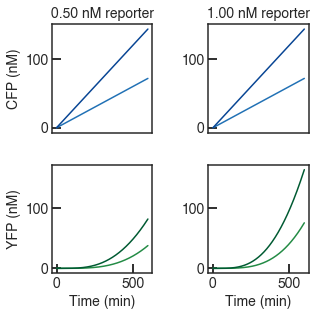

In [398]:
## Plot the results:
colorc = ['#2171b5','#084594']
colory = ['#238b45','#005a32']
# time_lim = (0,240)
# cfp_lim = (0,250)
# yfp_lim = (0,70)
figsize = (5,5)
fig = plt.figure(figsize=figsize)
index = 1
for rep_ind in range(num_reporter_conditions):

    if index == 1:
        axc = fig.add_subplot(2,num_integrase_conditions,index)
        axy = fig.add_subplot(2,num_reporter_conditions,index+2)
    else:
        axc = fig.add_subplot(2,num_integrase_conditions,index, sharey = axc)
        axy = fig.add_subplot(2,num_reporter_conditions,index+2, sharey = axy)
        
    for int_ind in range(num_integrase_conditions):
        axc.plot(timepoints, simdata[(int_levels[int_ind] ,rep_levels[rep_ind],'cfp')],
                 color=colorc[int_ind] )
        axy.plot(timepoints, simdata[(int_levels[int_ind] ,rep_levels[rep_ind],'yfp')]
                 ,color=colory[int_ind])
    
    axc.set_title('%1.2f nM reporter' % (rep_levels[rep_ind]))
    axy.set_xlabel('Time (min)')
    
    if index == 1:
        axc.set_ylabel('CFP (nM)')
        axy.set_ylabel('YFP (nM)')
    axc.set_xticks([])

    index += 1
    
fig.tight_layout()
# fig.savefig('integrase-minimal-simulation.svg')

We can see that the reduced model and the full model simulations are quite similar to each other but not exactly the same. This is expected as we have ignored certain dynamical aspects of the full model and assumed those to be steady in the reduced model. But the advantage with the reduced model is that instead of 8 species in the full model we now only have 3! Moreover, the number of parameters that we need to estimate has gone down as well (from 7 to 4). To finish the model reduction, we post process the model and write it as an SBML file (using BioCRNpyler). You may use your favorite SBML creator software to generate this `integrase_sbml_reduced.xml` file which consists of the reduced dynamics that we derived above.

## Post process model from AutoReduce
Create an SBML file for the reduced model using BioCRNpyler:

Save a copy of the reduced model object to restore later

In [399]:
import copy
save_reduced_model = copy.deepcopy(reduced_model)

In [400]:
# Uncomment to restore
# reduced_model = copy.deepcopy(save_reduced_model)

Create sympy Symbols out of parameters

In [401]:
save_reduced_model.params

[k_i, a_i, d_i, k_int, a_r, d_r, k, G_tot]

In [402]:
k_i, a_i, d_i, k_int, a_r, d_r, k, G_tot = reduced_model.params
params_dict = {}
for p, pval in zip(reduced_model.params, reduced_model.params_values):
    params_dict[str(p)] = pval

Add Hill coefficient as a parameter (if needed) so that it is identifiable from the data

In [403]:
[i for i in reduced_model.f[2].atoms()]

[G_tot, 2, a_i, k_int, d_i, Int, -1]

In [404]:
hill_coefficient = [i for i in reduced_model.f[2].atoms()][1]
n = Symbol('n')
reduced_model.f[2] = reduced_model.f[2].subs(hill_coefficient,n)
reduced_model.params.append(n)
reduced_model.params_values.append(hill_coefficient)

Simplify to find lumped parameter K_I = (d_i + k_int)/a_i

In [405]:
K_I_expr = (d_i + k_int)/a_i
K_I = Symbol('K_I')
numr = sympy.fraction(reduced_model.f[2])[0]/a_i
denr = sympy.fraction(reduced_model.f[2])[1]/a_i
reduced_model.f[2] = numr/denr
reduced_model.f[2] = sympy.simplify(reduced_model.f[2].subs(K_I_expr*a_i, K_I*a_i))
K_I_expr_value = K_I_expr
for p, pval in zip(reduced_model.params, reduced_model.params_values):
    K_I_expr_value = K_I_expr_value.subs(p, pval)

# Now remove parameters that got lumped, and add the lumped parameter
reduced_model.params.remove(d_i)
reduced_model.params_values.remove(params_dict['d_i'])
reduced_model.params.remove(a_i)
reduced_model.params_values.remove(params_dict['a_i'])
reduced_model.params.append(K_I)
reduced_model.params_values.append(K_I_expr_value)

In [406]:
reduced_model.params

[k_i, k_int, a_r, d_r, k, G_tot, n, K_I]

In [407]:
reduced_model.params

[k_i, k_int, a_r, d_r, k, G_tot, n, K_I]

In [408]:
sympy.Matrix(reduced_model.f)

Matrix([
[                                          0],
[                                    G_I*k_i],
[G_tot*k_int*pow(Int, n)/(K_I + pow(Int, n))],
[                                        A*k]])

In [409]:
from biocrnpyler import *
import sys
Int = Species("Int")
A = Species("A")
YFP = Species("YFP")
for p_symbol, p_value in zip(reduced_model.params, reduced_model.params_values):
    p_name = str(p_symbol)
    vars()[p_name] = ParameterEntry(p_name, float(p_value))
Gi = Species(str(reduced_model.x[0]))
G_tot = Species(str(reduced_model.params[-3]))
# G_tot = Species(str(reduced_model.params[-2]))
r0 = Reaction([],[Int], propensity_type = GeneralPropensity(f'{reduced_model.f[1]}', 
                                                            propensity_species=[Gi], 
                                                            propensity_parameters=[k_i]))
r1 = Reaction([],[A], propensity_type = GeneralPropensity(f'{reduced_model.f[2]}', 
                                                          propensity_species=[Int, G_tot], 
                                                          propensity_parameters=[k_int, K_I, n]))
# r1 = Reaction([],[A], propensity_type = GeneralPropensity(f'{reduced_model.f[2]}', 
#                                                           propensity_species=[Int, G_tot], 
#                                                           propensity_parameters=[k_int, K_I]))
r2 = Reaction([],[YFP], propensity_type = GeneralPropensity(f'{reduced_model.f[3]}',  
                                                          propensity_species=[A],
                                                          propensity_parameters=[k]))

model_crn = ChemicalReactionNetwork(species = [Int, A, YFP, Gi, G_tot], 
                        reactions = [r0, r1, r2])

model_crn.write_sbml_file("integrase_sbml_reduced.xml")

True

Make sure correct model was written by loading back the SBML

In [410]:
print(model_crn.pretty_print())

Species(N = 5) = {
YFP (@ 0),  Int (@ 0),  G_tot (@ 0),  G_I (@ 0),  A (@ 0),  
}

Reactions (3) = [
0.  --> Int
G_I*k_i
  k_i=0.24

1.  --> A
G_tot*k_int*pow(Int, n)/(K_I + pow(Int, n))
  k_int=0.05
  K_I=3335.0
  n=2.0

2.  --> YFP
A*k
  k=0.05

]


In [411]:
minimal_model = load_sbml(filename = "integrase_sbml_reduced.xml", outputs = ["Int", "YFP"])

In [413]:
sympy.Matrix(minimal_model.x)

Matrix([
[  Int],
[    A],
[  YFP],
[  G_I],
[G_tot]])

Sensitivity analysis of the minimal model:

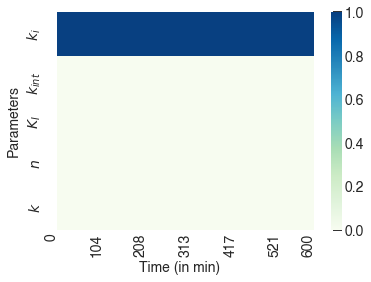

In [423]:
from bioscrape.analysis import py_sensitivity_analysis
import seaborn as sn
m = Model(sbml_filename = "integrase_sbml_reduced.xml")
int_levels = [0.5]
rep_levels = [0.5]
# int_levels = [0.25,0.5,0.75,1.]
# rep_levels = [0.25,0.5,0.75,1.]
timepoints = np.linspace(0,600,24, endpoint = True)
figsize = (6,4)
fig, ax = plt.subplots(nrows = len(int_levels), ncols= len(rep_levels), figsize=figsize)
index = 1
params_names_latex = ['$k_i$','$k_{int}$','$K_I$','$n$','$k$']
# params_names_latex = ['$k_i$','$k_{int}$','$K_I$','$k$']

for rep_ind in range(len(rep_levels)):
    rep_nm = rep_levels[rep_ind]
    for int_ind in range(len(int_levels)):
        int_nm = int_levels[int_ind]
        m.set_species({"G_I": int_nm, "G_tot": rep_nm})
        SSM = py_sensitivity_analysis(m, timepoints, normalize = True)
        sn_ax = sn.heatmap(SSM[:,:,0].T, ax = ax, cmap = 'GnBu', 
                           xticklabels = np.linspace(timepoints[0],timepoints[-1], len(timepoints),
                                                     endpoint = True,dtype = 'int'))
    index += 1
sn_ax.figure.axes[-1].xaxis.label.set_size(20)
ax = fig.axes
_ = plt.xlabel('Time (in min)', fontsize = 14)
_ = plt.ylabel('Parameters', fontsize = 14)
# plt.locator_params(axis='x', nbins=15)
_ = ax[0].tick_params(axis='x', which='major', labelsize=14, bottom = False)
_ = ax[0].tick_params(axis='y', which='major', labelsize=14, left = False)
_ = ax[0].set_yticklabels(params_names_latex)
every_nth = 4
for n, label in enumerate(ax[0].xaxis.get_ticklabels()):
    if n == len(timepoints)-1:
        continue
    if n % every_nth != 0:
        label.set_visible(False)
_ = ax[1].tick_params(axis = 'x', labelsize = 18)
# _ = plt.savefig('minimal-integrase-sensitivity-25-25.svg')
plt.show()

In [418]:
m.get_species_list()

['Int', 'A', 'YFP', 'G_I', 'G_tot']

### Now load `integrase_sbml_reduced` to Data Analysis of Integrase Activity.ipynb.